## Code

In [ ]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from tqdm import tqdm


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('/content/drive/My Drive/images.npz')
raw_labels = load_data('/content/drive/My Drive/labels.npz')

In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    labels = np.zeros((8,8,8))
    # print(raw_labels[0].shape)
    # print(raw_labels)
    for label in raw_labels:
      object_class, x1, y1, x2, y2 = label
      bb_center_x = (x2+x1)/2
      bb_center_y = (y2+y1)/2

      grid_x = int(bb_center_x/16) 
      grid_y = int(bb_center_y/16)

      center_grid_x = (bb_center_x%16)/16
      center_grid_y = (bb_center_y%16)/16

      width  = (x2-x1)/128
      height = (y2-y1)/128

      object_prob = np.zeros(3)

      #l[0] had object class
      object_prob[int(label[0])] = 1

      labels[0, grid_x, grid_y] = 1
      labels[1:5, grid_x, grid_y] = [center_grid_x,center_grid_y,width,height]

      labels[5:, grid_x, grid_y] = object_prob
    # print(labels.shape)
    # print(labels)
    return labels

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    #labels is 8x8x8
    object_list = []
    grid_idx_list = []
    for idxs in np.argwhere(labels[0]==1):
      object_list.append(labels[:,idxs[0],idxs[1]])
      grid_idx_list.append(idxs)
    # print(grid_idx_list)
    raw_labels = np.zeros((len(object_list), 5))
    for i, obj in enumerate(object_list):
        raw_labels[i][0] = float(np.argwhere(obj[5:]==1))

        eqn_1_x = obj[3]*img_dim
        eqn_1_y = obj[4]*img_dim
        # print(eqn_1_x, eqn_1_y) # x2-x1, y2-y1
        grid_x = grid_idx_list[i][0]
        grid_y = grid_idx_list[i][1]

        center_grid_x_offset = obj[1]*16
        center_grid_y_offset = obj[2]*16

        eqn_2_x = 2*((grid_x)*16 + center_grid_x_offset)
        eqn_2_y = 2*((grid_y)*16 + center_grid_y_offset)
        # print(eqn_2_x, eqn_2_y) # x1+x2, y1+y2
        raw_labels[i][-2] = (eqn_1_x+eqn_2_x)/2
        raw_labels[i][-1] = (eqn_1_y+eqn_2_y)/2

        raw_labels[i][-3] = (eqn_2_y - eqn_1_y)/2
        raw_labels[i][-4] = (eqn_2_x - eqn_1_x)/2

    return raw_labels

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels_inference(preds, img_dim=128):
    #labels is nx8x8x8
    labels = preds.squeeze().detach().cpu().numpy()
    object_list = []
    grid_idx_list = []
    for idxs in np.argwhere(labels[0]>0):
      object_list.append(labels[:,idxs[0],idxs[1]])
      grid_idx_list.append(idxs)
    raw_labels = np.zeros((len(object_list), 6))
    for i, obj in enumerate(object_list):
        # print(obj[5:])
        raw_labels[i][0] = float(np.argmax(obj[5:]))

        eqn_1_x = obj[3]*img_dim
        eqn_1_y = obj[4]*img_dim
        # print(eqn_1_x, eqn_1_y) # x2-x1, y2-y1
        grid_x = grid_idx_list[i][0]
        grid_y = grid_idx_list[i][1]

        center_grid_x_offset = obj[1]*16
        center_grid_y_offset = obj[2]*16

        eqn_2_x = 2*((grid_x)*16 + center_grid_x_offset)
        eqn_2_y = 2*((grid_y)*16 + center_grid_y_offset)
        # print(eqn_2_x, eqn_2_y) # x1+x2, y1+y2
        raw_labels[i][-2] = (eqn_1_x+eqn_2_x)/2
        raw_labels[i][-1] = (eqn_1_y+eqn_2_y)/2

        raw_labels[i][-3] = (eqn_2_y - eqn_1_y)/2
        raw_labels[i][-4] = (eqn_2_x - eqn_1_x)/2

    return raw_labels

In [ ]:
def yolo_loss(output, target):
    # print(output.shape, target.shape)
    # print(type(output), type(target))
    object_idx  = target[:,0,:,:].nonzero()
    nobject_idx = (target[:,0,:,:]==0).nonzero()
    # print(object_idx[0,:], nobject_idx[0,:])
    target_object    = target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
    predicted_object = output[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]

    predicted_nobject = output[nobject_idx[:,0],:,nobject_idx[:,1],nobject_idx[:,2]]

    localization_loss = torch.sum((target_object[:,1]-predicted_object[:,1])**2 +
                                  (target_object[:,2]-predicted_object[:,2])**2)

    bbox_loss         = torch.sum((torch.sqrt(target_object[:,3])-torch.sqrt(predicted_object[:,3]))**2 +
                                  (torch.sqrt(target_object[:,4])-torch.sqrt(predicted_object[:,4]))**2)
    
    ##########################################
    prediction = predicted_object[:, 1:5]
    grnd_truth = target_object[:, 1:5]

    cpx = prediction[:,0]
    cpy = prediction[:,1]
    wp = prediction[:,2]
    hp = prediction[:,3]
    
    
    cgx = grnd_truth[:,0]
    cgy = grnd_truth[:,1]
    wg = grnd_truth[:,2]
    hg = grnd_truth[:,3]
    
    wp= wp * 128
    hp= hp * 128
    wg= wg * 128
    hg= hg * 128

    cpx = cpx * 16 + object_idx[:,0] * 16
    cpy = cpy * 16 + object_idx[:,1] * 16
    cgx = cgx * 16 + object_idx[:,0] * 16
    cgy = cgy * 16 + object_idx[:,1] * 16

    box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
    box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

    xA = torch.max(box1[0], box2[0])
    yA = torch.max(box1[1], box2[1])

    xB = torch.min(box1[2], box2[2])
    yB = torch.min(box1[3], box2[3])

    area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device=xB.device)) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device=yB.device))

    area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

    iou = torch.clip(torch.div(area_intersection+1,area_union+1), 0, 1)
    ##########################
    obj_confidence_loss = torch.sum((iou - predicted_object[:,0])**2)
    # obj_confidence_loss = torch.sum((1 - predicted_object[:,0])**2)
    nobj_confidence_loss= torch.sum((0 - predicted_nobject[:, 0])**2)
    pc_loss = torch.sum((target_object[:,5:]-predicted_object[:,5:])**2)
    loss = 5.0*(localization_loss + bbox_loss) + obj_confidence_loss + 0.5*nobj_confidence_loss + pc_loss

    return loss

In [ ]:
train_loss, val_loss, mAP_train = [], [], []
class YOLO(pl.LightningModule):
    def __init__(self):
      super(YOLO, self).__init__()
      self.model_url = ""
      self.relu = torch.nn.ReLU(inplace=False)
      
      self.conv1 = torch.nn.Conv2d(3,32,kernel_size=4,padding=1, stride=2)
      self.batch_norm1 = torch.nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)
      
      self.conv2 = torch.nn.Conv2d(32,64,kernel_size=4,padding=1, stride=2)
      self.batch_norm2 = torch.nn.BatchNorm2d(64,eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)

      self.conv3 = torch.nn.Conv2d(64,128,kernel_size=4,padding=1, stride=2)
      self.batch_norm3 = torch.nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)
      
      self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=4,padding=1, stride=2)
      self.batch_norm4 = torch.nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)
      
      self.conv5 = torch.nn.Conv2d(256,512,kernel_size=4,padding=1, stride=2)
      self.batch_norm5 = torch.nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)
      
      self.conv6 = torch.nn.Conv2d(512,1024, kernel_size=4,padding=1, stride=2)
      self.batch_norm6 = torch.nn.BatchNorm2d(1024, eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)

      self.conv7 = torch.nn.ConvTranspose2d(1024, 256, kernel_size=4,padding=1, stride=2)
      self.batch_norm7 = torch.nn.BatchNorm2d(256, eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)
      
      self.conv8 = torch.nn.ConvTranspose2d(256, 64, kernel_size=4,padding=1, stride=2)
      self.batch_norm8 = torch.nn.BatchNorm2d(64, eps=1e-05,momentum=0.1,
                                              affine=True,track_running_stats=True)

      self.conv9 = torch.nn.Conv2d(64, 8, kernel_size=3, padding=1, stride=1)


    def forward(self, x):
      layer1 = self.relu(self.batch_norm1(self.conv1(x)))
      layer2 = self.relu(self.batch_norm2(self.conv2(layer1)))
      layer3 = self.relu(self.batch_norm3(self.conv3(layer2)))
      layer4 = self.relu(self.batch_norm4(self.conv4(layer3)))
      layer5 = self.relu(self.batch_norm5(self.conv5(layer4)))
      layer6 = self.relu(self.batch_norm6(self.conv6(layer5)))
      layer7 = self.relu(self.batch_norm7(self.conv7(layer6)))
      layer8 = self.relu(self.batch_norm8(self.conv8(layer7)))
      out = torch.sigmoid(self.conv9(layer8))
      return out      

    def training_step(self, batch, batch_idx):
        input, label = batch
        input, label = input.to(device), label.to(device)

        output = self(input)
        loss = yolo_loss(output, label)
        self.log("train_loss", loss)
        train_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        input, label = batch
        input, label = input.to(device), label.to(device)
        output = self(input)
        loss = yolo_loss(output, label)
        self.log("val_loss", loss)
        val_loss.append(loss.item())
        # mAP_train.append(calculate_map(test_loader))

        return output, label

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=10e-4)

    def load_from_url():
      return YOLO.load_from_checkpoint(YOLO.model_url) 

In [ ]:
def iou_nms(coord1, coord2, nms_output):
  #Extracting centers and h w
  cpx = nms_output[1,coord1[0],coord1[1]]
  cpy = nms_output[2,coord1[0],coord1[1]]
  wp  = nms_output[3,coord1[0],coord1[1]]
  hp  = nms_output[4,coord1[0],coord1[1]]
  
  
  cgx = nms_output[1,coord2[0],coord2[1]]
  cgy = nms_output[2,coord2[0],coord2[1]]
  wg  = nms_output[3,coord2[0],coord2[1]] 
  hg  = nms_output[4,coord2[0],coord2[1]]
  
  #Rescaling width and height
  wp= wp * 128
  hp= hp * 128
  wg= wg * 128
  hg= hg * 128

  #Rescaling center
  cpx = cpx * 16 + coord1[0] * 16
  cpy = cpy * 16 + coord1[1] * 16
  cgx = cgx * 16 + coord2[0] * 16
  cgy = cgy * 16 + coord2[1] * 16

  #Box format [x1 y1 x2 y2]
  box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
  box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

  xA = torch.max(box1[0], box2[0])
  yA = torch.max(box1[1], box2[1])

  xB = torch.min(box1[2], box2[2])
  yB = torch.min(box1[3], box2[3])

  area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device=xB.device)) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device=yB.device))

  area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

  iou = torch.div(area_intersection+1,area_union+1)
  return iou

In [ ]:
def low_confidence_suppression(label):
    below_threshold = torch.le(label[:,0,:,:],0.6).nonzero()
    label[below_threshold[:,0], 0, below_threshold[:,1], below_threshold[:,2]] = 0
    return label

def non_max_suppression(label):
  #network output (n,8,8,8)

    classes = 3
    nms_threshold = 0.3
    for i in range(label.shape[0]):
      for c in range(classes):
        grid_coords = torch.logical_and(torch.max(label[i,5:8,:,:],dim=0)[1] == c , label[i,0,:,:]>nms_threshold).nonzero() 
        for coord1 in grid_coords:
          confidence_score_c1 = label[i,0,coord1[0],coord1[1]] * label[i,5+c,coord1[0],coord1[1]]
          for coord2 in grid_coords:
            confidence_score_c2 = label[i,0,coord2[0],coord2[1]] * label[i,5+c,coord2[0],coord2[1]]
            if(iou_nms(coord1, coord2, label[i,:,:,:])>0.5 and confidence_score_c1<confidence_score_c2):
              label[i,0,coord1[0],coord1[1]] = 0
    return label

In [ ]:
def average_precision(matches, scores, trues):

  matches = np.asarray(matches)
  scores = np.asarray(scores)
  max = np.max(scores)


  ln  = np.linspace(0.6, max, 100)
  recall_mat = np.zeros((101))
  precision_mat = np.zeros((101))

  for i, th in enumerate(ln):
    TP = np.sum(matches[scores>th])
    P  = matches[scores>th].shape[0]

    precision = 1
    if P>0:
      precision = TP/P

    recall =1
    if trues>0:
      recall = TP/trues
    precision_mat[i] = precision
    recall_mat[i] = recall

  recall_mat[100]    = 0
  precision_mat[100] = 1

  sorted_ind       = np.argsort(recall_mat)
  sorted_recall    = recall_mat[sorted_ind]
  sorted_precision = precision_mat[sorted_ind]
  area = metrics.auc(sorted_recall, sorted_precision)
  
  return area, recall_mat, precision_mat

In [ ]:
from sklearn import metrics 
def yolo_evaluation(output, target):
  iou_thresh = 0.5

  object_idx  = output[:,0,:,:].nonzero()
  nobject_idx = (output[:,0,:,:]==0).nonzero()

  target_object    = target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
  predicted_object = output[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
  prediction = predicted_object[:, 1:5]
  grnd_truth = target_object[:, 1:5]
  
  #########################################
  cpx = prediction[:,0]
  cpy = prediction[:,1]
  wp = prediction[:,2]
  hp = prediction[:,3]
  
  
  cgx = grnd_truth[:,0]
  cgy = grnd_truth[:,1]
  wg = grnd_truth[:,2]
  hg = grnd_truth[:,3]
  
  wp= wp * 128
  hp= hp * 128
  wg= wg * 128
  hg= hg * 128

  cpx = cpx * 16 + object_idx[:,0] * 16
  cpy = cpy * 16 + object_idx[:,1] * 16
  cgx = cgx * 16 + object_idx[:,0] * 16
  cgy = cgy * 16 + object_idx[:,1] * 16

  box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
  box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

  xA = torch.max(box1[0], box2[0])
  yA = torch.max(box1[1], box2[1])

  xB = torch.min(box1[2], box2[2])
  yB = torch.min(box1[3], box2[3])

  area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device=xB.device)) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device=yB.device))

  area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

  iou = torch.clip(torch.div(area_intersection+1,area_union+1), 0, 1)

  ###########################################


  confidence_scores = output[object_idx[:,0],0,object_idx[:,1],object_idx[:,2]] * torch.max(output[object_idx[:,0],5:8,object_idx[:,1],object_idx[:,2]],dim=1)[0]
  batch_proc = []
  
  for one_op in range(output.shape[0]):
    batch_proc.append(reconstruct_raw_labels_inference(output[one_op]))
  
  idx_cnt = 0
  batch_idxs = torch.unique(object_idx[:,0])
  # print(confidence_scores)
  for i in range(len(batch_proc)):
    if i in batch_idxs:
      batch_proc[i][:,1] = (confidence_scores[idx_cnt:idx_cnt+batch_proc[i].shape[0]]).cpu().numpy() 
      
      idx_cnt += batch_proc[i].shape[0]
    else:
      batch_proc[i] = None
  classes = torch.max(output[object_idx[:,0],5:8,object_idx[:,1],object_idx[:,2]],dim=1)[1] 
  all_matches = torch.gt(iou,iou_thresh)

  trues_idx  = target[:,0,:,:].nonzero()
  target_classes    = torch.max(target[trues_idx[:,0],5:8,trues_idx[:,1],trues_idx[:,2]], dim=1)[1]

  total_classes = 3
  trues = {}
  scores = {}
  matches = {}
  for c in range(total_classes):
    trues[c]=(torch.sum(target_classes == c)).item()
    scores[c]=(confidence_scores[classes==c]).cpu().tolist()
    matches[c]=(all_matches[classes==c]).cpu().tolist()
  return matches, scores, trues, batch_proc

In [ ]:
def calculate_map(test_loader, plot=False):
  matches= {0:[],1:[],2:[]}
  scores = {0:[],1:[],2:[]}
  trues  = {0:0,1:0,2:0}
  classes =3
  predicted_labels = []

  with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
      # recon_label = reconstruct_raw_labels(label.squeeze().detach().numpy())
      image, label = image.cuda(), label.cuda()
      output = model(image)
      low_thresh_output = low_confidence_suppression(output)
      nms_output = non_max_suppression(low_thresh_output)

      m, s, t, batch_proc = yolo_evaluation(nms_output, label)
      predicted_labels += batch_proc
      
      for c in range(classes): 
            if(len(m[c])>0):
              matches[c].extend(m[c])
            if(len(s[c])>0):
              # print(s[c])
              scores[c].extend(s[c])
            trues[c]  = trues[c]+t[c]

  AP=0
  cnt=0
  mAP = 0
  for c in range(classes):
    if (len(matches[c])>0):

      area, recall_mat, precision_mat = average_precision(matches[c],scores[c],trues[c])
      AP  += area
      # print(recall_mat, precision_mat)
      if plot:
        plt.figure()
        plt.plot(recall_mat, precision_mat)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Curve for class "+str(c))
        plt.show()
        print("class ", c, ":",AP)
      cnt+=1;
  if cnt>0:
    mAP=AP/cnt

  return mAP, predicted_labels

In [ ]:
def plot_bbox(image, recon_labels):
  fig, ax = plt.subplots()
  ax.imshow(image)

  for label in recon_labels: #class, x1, y1, x2, y2
    if label[0]==0:
      rect = patches.Rectangle((label[1], label[4]), label[3]-label[1], label[2]-label[4], linewidth=2, edgecolor='b', facecolor='none')
      ax.add_patch(rect)
    if label[0]==1:
      rect = patches.Rectangle((label[1], label[4]), label[3]-label[1], label[2]-label[4], linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
    if label[0]==2:
      rect = patches.Rectangle((label[1], label[4]), label[3]-label[1], label[2]-label[4], linewidth=2, edgecolor='g', facecolor='none')
      ax.add_patch(rect)

  plt.show()

#### Showing the chosen image with ground truth bounding boxes visualized.

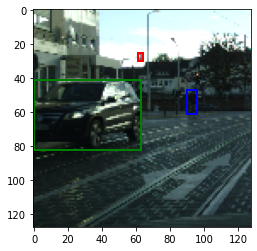

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
chosen_img_idx = 0 #531
for idx, label in enumerate(raw_labels):
  if label.shape[0]==3:
    if (0 in label[:,0] and 1 in label[:,0] and 2 in label[:,0]):
      chosen_img_idx = idx
      break

plot_bbox(images[chosen_img_idx], raw_labels[chosen_img_idx])


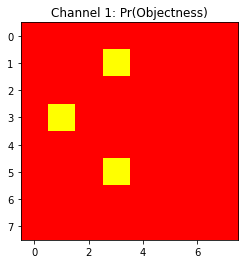

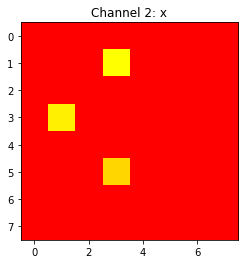

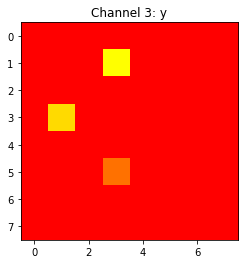

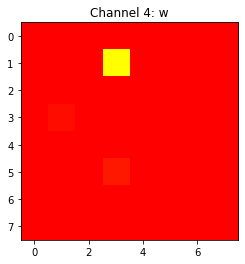

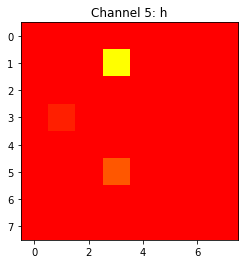

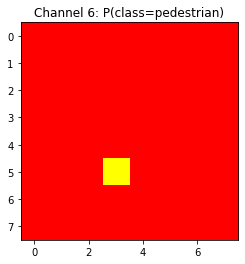

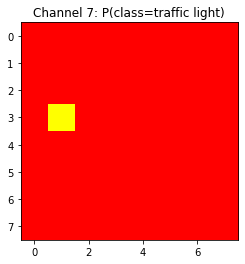

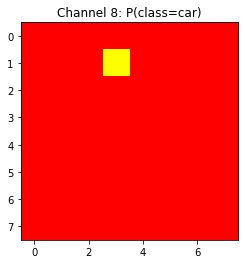

In [ ]:
# Visualize the 8x8x8 representation.
processed_labels = process_labels(raw_labels[chosen_img_idx])
titles = ["Channel 1: Pr(Objectness)", "Channel 2: x", "Channel 3: y", "Channel 4: w", "Channel 5: h", "Channel 6: P(class=pedestrian)", "Channel 7: P(class=traffic light)", "Channel 8: P(class=car)"]
for i in range(processed_labels.shape[0]):
  plt.imshow( processed_labels[i] , cmap = 'autumn' , interpolation = 'nearest' )
  plt.title(titles[i])
  plt.show()

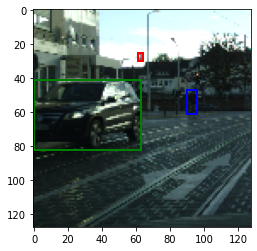

In [ ]:

recon_labels = reconstruct_raw_labels(processed_labels)


plot_bbox(images[chosen_img_idx], recon_labels)

 Implementing the loss function

Block diagram of the architecture

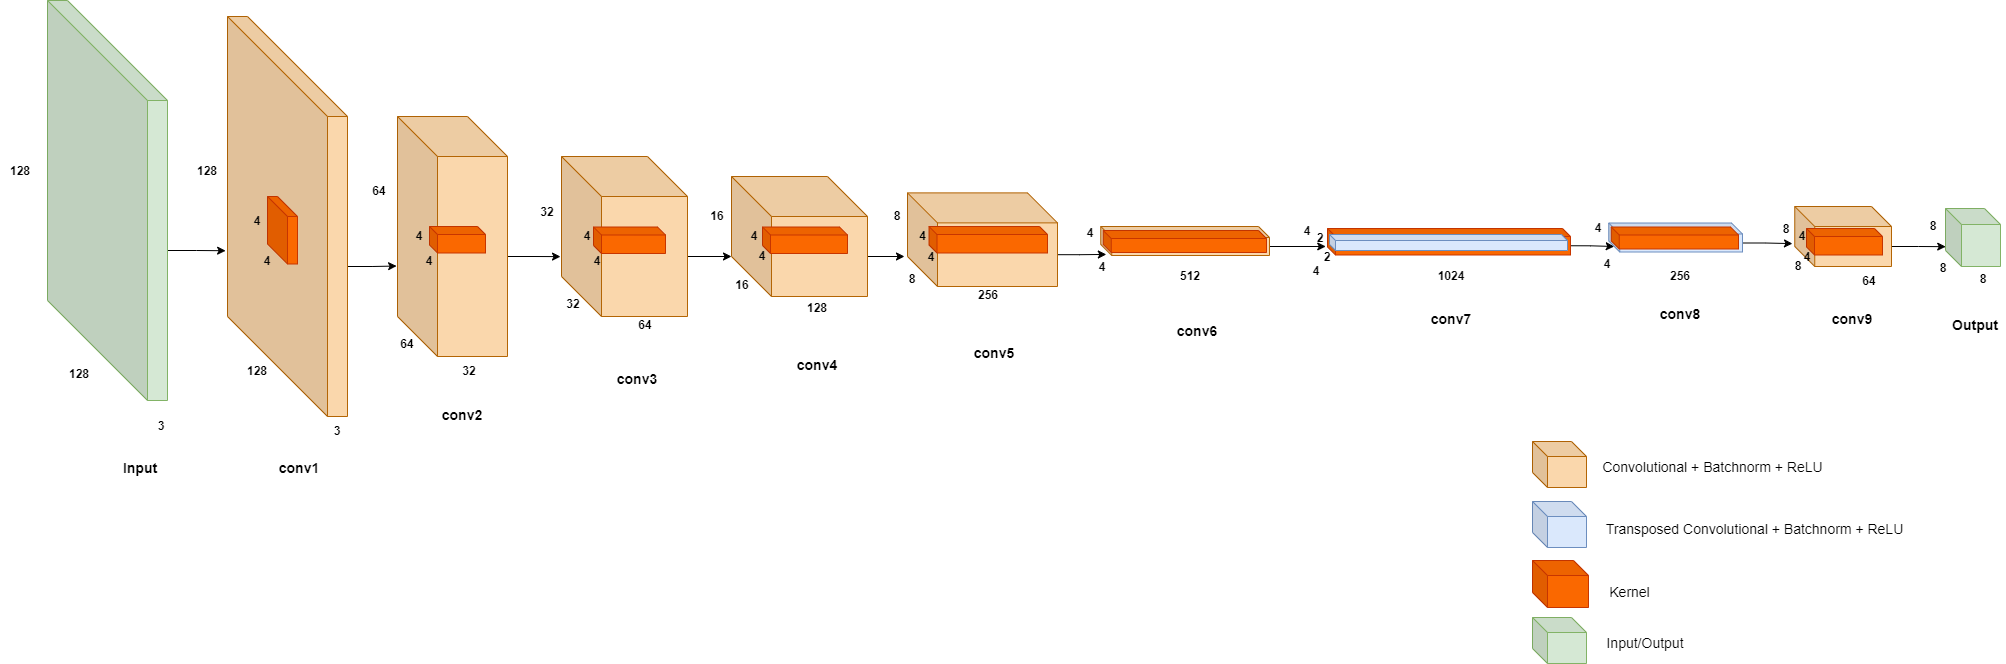

Plot of the loss over training for your model.

In [ ]:
%reload_ext tensorboard

#### Creating Custom Dataset and dataloaders

In [ ]:
# Setup your training
model = YOLO().to(device)
checkpoint_callback = pl_callbacks.ModelCheckpoint()
tb_logger = pl_loggers.TensorBoardLogger("log/")

class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, images, raw_labels):
        self.images = images
        self.labels = raw_labels
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = np.transpose(self.images[idx], (2,0,1))
        targets = process_labels(self.labels[idx])
        images, targets = torch.Tensor(images), torch.Tensor(targets)
        images = images/255.0
        return images, targets


train_dataset = CustomDataset(images[:int(0.8*len(images))], raw_labels[:int(0.8*len(images))])
test_dataset = CustomDataset(images[int(0.8*len(images)):], raw_labels[int(0.8*len(images)):])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

#### Training the model

In [ ]:
# Train your model
trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=20, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, test_loader)

In [ ]:
# Plot the results
%tensorboard --logdir log

#### Training Loss

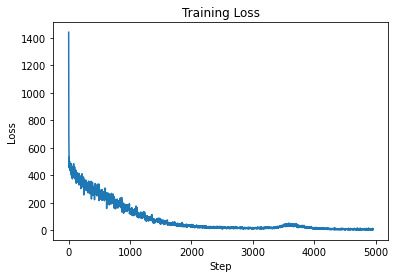

In [ ]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

#### Validation Loss

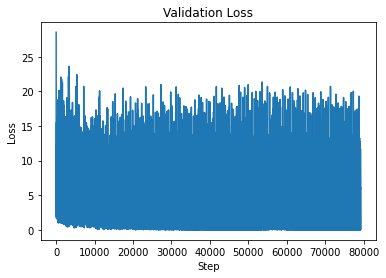

In [ ]:
plt.plot(val_loss)
plt.title("Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

Plot of the mean Average Precision over training 

In [ ]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4)
map_train = []
for e in tqdm(range(epochs)):
  for i, (image,label) in enumerate(train_loader):
    image, label = image.to(device), label.to(device)
    optimizer.zero_grad()
    output = model(image)

    loss = yolo_loss(output, label)
    loss.backward()
    optimizer.step()
  
  # test for map
  m, _ = calculate_map(test_loader)
  # print(m)
  map_train.append(m)



100%|██████████| 20/20 [16:44<00:00, 50.21s/it]


Text(0.5, 1.0, 'mAP over training')

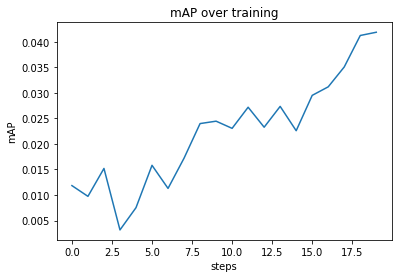

In [ ]:
plt.plot(map_train)
plt.xlabel("steps")
plt.ylabel("mAP")
plt.title("mAP over training")

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/latest_latest.pth'))

<All keys matched successfully>

In [ ]:
def plot_bbox2(image, output, title):
  image_size_w=image_size_h=128
  grid_size = 16
  thresh = 0
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.imshow(np.uint8(image.numpy().transpose((1,2,0))))
  plt.title(title)
  idx = torch.gt(output[0,:,:],thresh)
  grid = torch.nonzero(idx)
  boxes = output[:, idx]

  for i in range(boxes.shape[1]):
    width    = boxes[3,i] * image_size_w
    height   = boxes[4,i] * image_size_h
    center_x = boxes[1,i] * grid_size + (grid[i, 0] * grid_size)
    center_y = boxes[2,i] * grid_size + (grid[i, 1] * grid_size)
    if(torch.gt(boxes[5,i],thresh) and torch.gt(boxes[5,i],boxes[6,i]) and torch.gt(boxes[5,i],boxes[7,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
      ax.add_patch(rect)
    
    if(torch.gt(boxes[6,i],thresh) and torch.gt(boxes[6,i],boxes[5,i]) and torch.gt(boxes[6,i],boxes[7,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
      ax.add_patch(rect)

    if(torch.gt(boxes[7,i],thresh) and torch.gt(boxes[7,i],boxes[6,i]) and torch.gt(boxes[7,i],boxes[5,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
      ax.add_patch(rect)

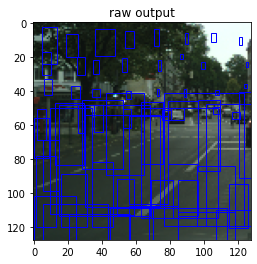

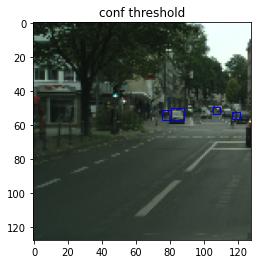

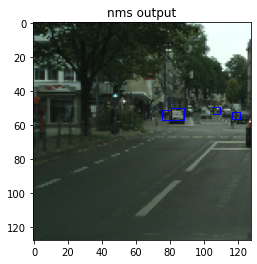

In [ ]:
for idx, (image, label) in enumerate(test_loader):
  
    image, label = image.cuda(), label.cuda()
    output = model(image)
    plot_bbox2((image[0]*255).detach().cpu(), output[0].detach().cpu(), "raw output")
    low_thresh_output = low_confidence_suppression(output)
    plot_bbox2((image[0]*255).detach().cpu(), low_thresh_output[0].detach().cpu(), "conf threshold")
    nms_output = non_max_suppression(low_thresh_output)
    plot_bbox2((image[0]*255).detach().cpu(), nms_output[0].detach().cpu(), "nms output")

    break

In [ ]:
def plot_bbox3(image, output, title):
  image_size_w=image_size_h=128
  grid_size = 16
  thresh = 0
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.imshow(np.uint8(image.numpy().transpose((1,2,0))))
  idx = torch.gt(output[0,:,:],thresh)
  grid = torch.nonzero(idx)
  boxes = output[:, idx]
  plt.title(title)

  for i in range(boxes.shape[1]):
    width    = boxes[3,i] * image_size_w
    height   = boxes[4,i] * image_size_h
    center_x = boxes[1,i] * grid_size + (grid[i, 0] * grid_size)
    center_y = boxes[2,i] * grid_size + (grid[i, 1] * grid_size)
    if(torch.gt(boxes[5,i],thresh) and torch.gt(boxes[5,i],boxes[6,i]) and torch.gt(boxes[5,i],boxes[7,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)
    
    if(torch.gt(boxes[6,i],thresh) and torch.gt(boxes[6,i],boxes[5,i]) and torch.gt(boxes[6,i],boxes[7,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
      ax.add_patch(rect)

    if(torch.gt(boxes[7,i],thresh) and torch.gt(boxes[7,i],boxes[6,i]) and torch.gt(boxes[7,i],boxes[5,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='g',facecolor='none')
      ax.add_patch(rect)

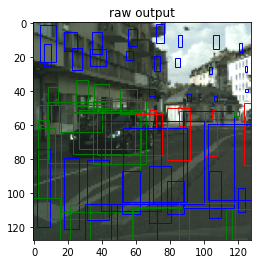

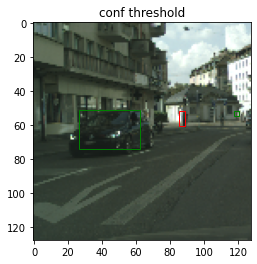

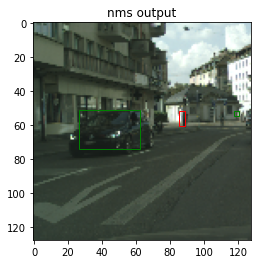

In [ ]:
for idx, (image, label) in enumerate(test_loader):
  if idx==100:
    image, label = image.cuda(), label.cuda()
    output = model(image)
    # print(reconstruct_raw_labels(label[0].detach().cpu().numpy()))
    plot_bbox3((image[0]*255).detach().cpu(), output[0].detach().cpu(), "raw output")
    low_thresh_output = low_confidence_suppression(output)
    plot_bbox3((image[0]*255).detach().cpu(), low_thresh_output[0].detach().cpu(), "conf threshold")
    nms_output = non_max_suppression(low_thresh_output)
    plot_bbox3((image[0]*255).detach().cpu(), nms_output[0].detach().cpu(), "nms output")

    break

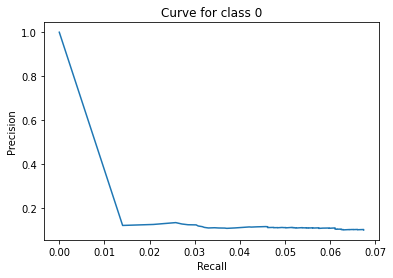

class  0 : 0.014018742866917174


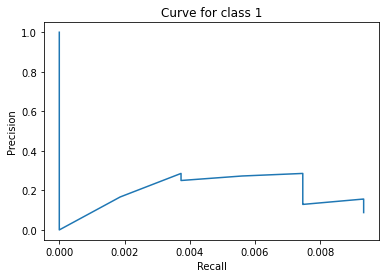

class  1 : 0.015740248972751638


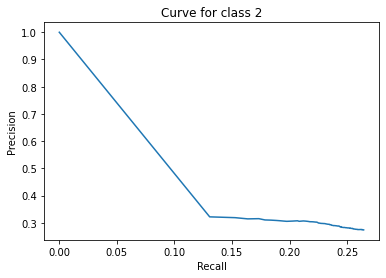

class  2 : 0.1428127392703727
Mean Average Precision  0.047604246423457564


In [ ]:
map, predicted_labels = calculate_map(test_loader, plot=True)
print("Mean Average Precision ", map)

# final_labels = []
# for i in range(9900):
#   if i>(9900-1980):
#     final_labels.append(predicted_labels[9900-1980-i])
#   else:
#     final_labels.append(None)
# final_labels = np.array(final_labels)
# print(final_labels.shape)

# from numpy import savez_compressed
# savez_compressed('labels.npz', final_labels)